In [1]:
import sys

import matplotlib.pyplot as plt
import missingno as msno
import networkx as nx
import numpy as np
import pandas as pd

print('python:'.ljust(16), sys.version.split('\n')[0])

python:          3.9.12 (main, Apr  5 2022, 01:53:17) 


## Define constants

In [2]:
DATA_PATH = './data/'
GRAPH_ROOT = 1

TARGET = 'category_id'  # Target feature
IDENT = 'id'  # ID feature
TRAIN = 'TRAIN'  # Binary feature to separate train and test data

## Load data

In [3]:
# Load datasets
tree = pd.read_csv(DATA_PATH + 'categories_tree.csv')
df_train = pd.read_parquet(DATA_PATH + 'train.parquet', 'pyarrow')
df_test = pd.read_parquet(DATA_PATH + 'test.parquet', 'pyarrow')

# Join train and test datasets
df_test[TARGET] = pd.NA  # Fill target variable of the test dataset with zeros
df_train[TRAIN] = True  # Train/test flag
df_test[TRAIN] = False  # Train/test flag
df = pd.concat([df_train, df_test], ignore_index=True)

## Preprocess data

In [4]:
# Replace 0.0 rating with NaN
df.loc[df['rating'] == 0.0, 'rating'] = np.nan

## View df general info

In [5]:
df

,id,title,short_description,name_value_characteristics,rating,feedback_quantity,category_id,TRAIN
0,1267423,Muhle Manikure Песочные колпачки для педикюра ...,Muhle Manikure Колпачок песочный шлифовальный ...,None,NaN,0,2693,True
1,128833,"Sony Xperia L1 Защитное стекло 2,5D",None,None,4.666667,9,13408,True
2,569924,"Конверт для денег Прекрасная роза, 16,5 х 8 см","Конверт для денег «Прекрасная роза», 16,5 × 8 см",None,5.000000,6,11790,True
3,1264824,Серьги,None,None,NaN,0,14076,True
4,1339052,Наклейки на унитаз для туалета на крышку бачок...,"Водостойкая, интересная наклейка на унитаз раз...",None,NaN,0,12401,True
...,...,...,...,...,...,...,...,...
354311,967535,Носки с мехом куницы авокадо разноцветные,Пуховые носки с мехомом куницы с авакадо.,None,5.000000,3,<NA>,False
354312,1488636,"Эфирное масло Сосны, 10 мл, от КедрМаркет","Масло сосны повышает защитную функцию кожи, уп...",None,NaN,0,<NA>,False
354313,827510,Компект (футболка+шорты),"Отличный комплект. Удобный, комфортный.",None,NaN,0,<NA>,False
354314,529244,Купальный костюм Mark Formelle,None,Российский размер:40|42|44|46,NaN,0,<NA>,False


In [6]:
df.loc[df[TRAIN]].info()
print()
df.loc[~df[TRAIN]].info()
print()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283452 entries, 0 to 283451
Data columns (total 8 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          283452 non-null  int64  
 1   title                       283452 non-null  object 
 2   short_description           133130 non-null  object 
 3   name_value_characteristics  50360 non-null   object 
 4   rating                      111291 non-null  float64
 5   feedback_quantity           283452 non-null  int64  
 6   category_id                 283452 non-null  object 
 7   TRAIN                       283452 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(4)
memory usage: 17.6+ MB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70864 entries, 283452 to 354315
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id  

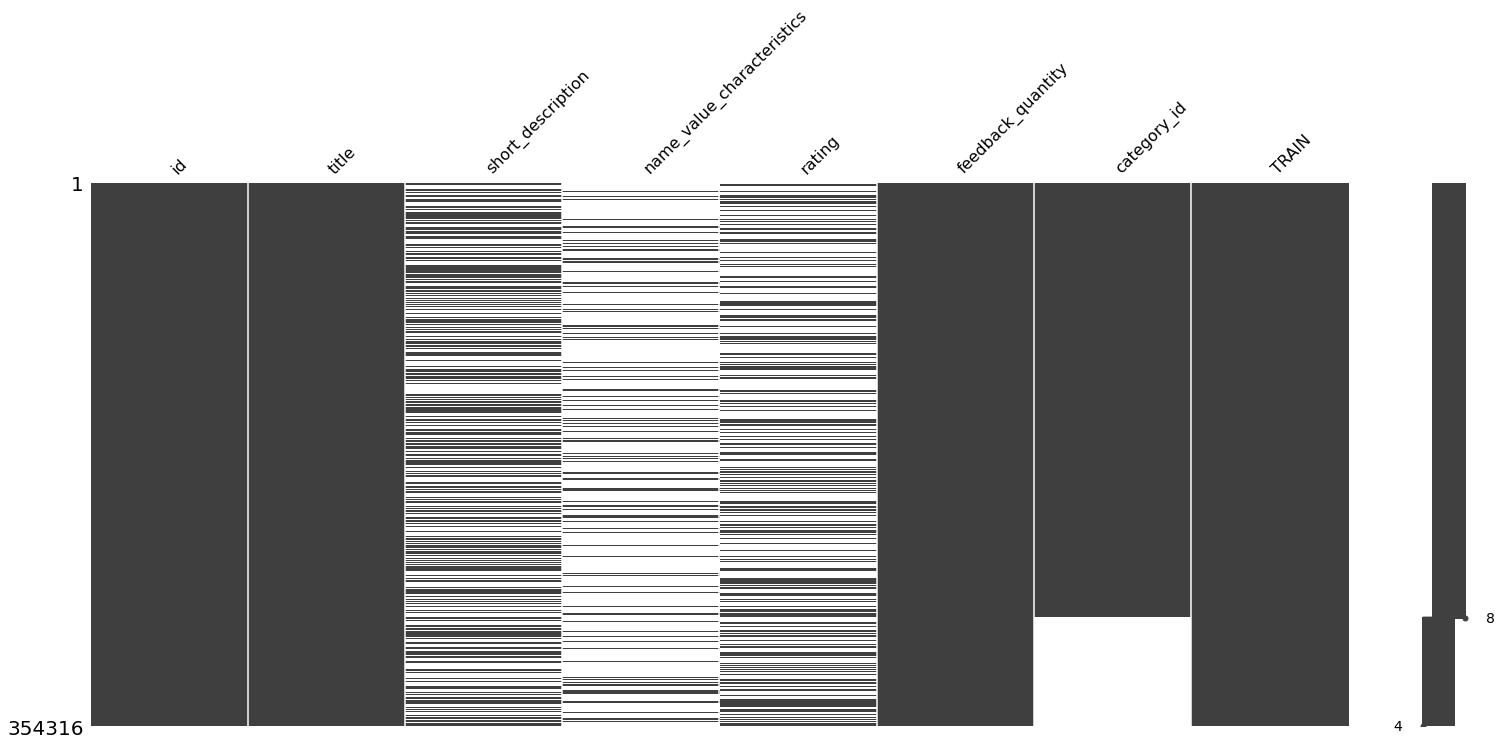

In [7]:
msno.matrix(df);

## View historgams

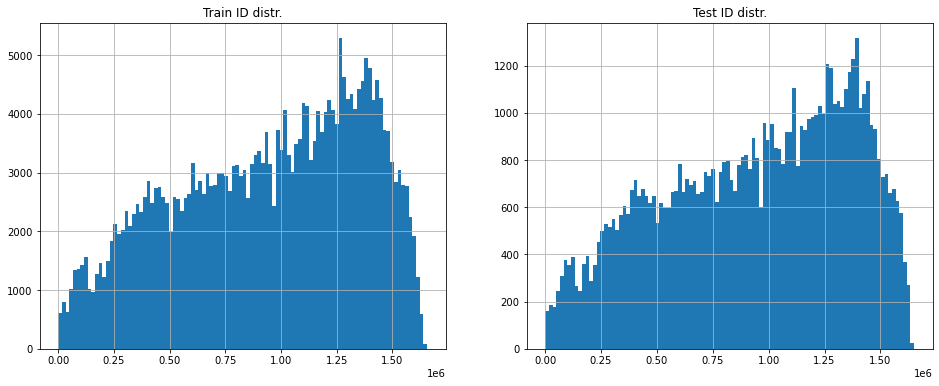

In [8]:
fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
df.loc[df[TRAIN], IDENT].hist(bins=100, ax=axes[0])
df.loc[~df[TRAIN], IDENT].hist(bins=100, ax=axes[1])
axes[0].set_title('Train ID distr.')
axes[1].set_title('Test ID distr.')
plt.show()

ID distributions for train and test parts are similar. ID may represent some timing characteristic and therefore may be a useful feature.

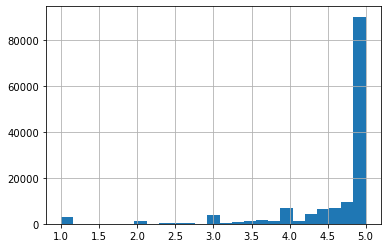

In [9]:
df['rating'].hist(bins=25);

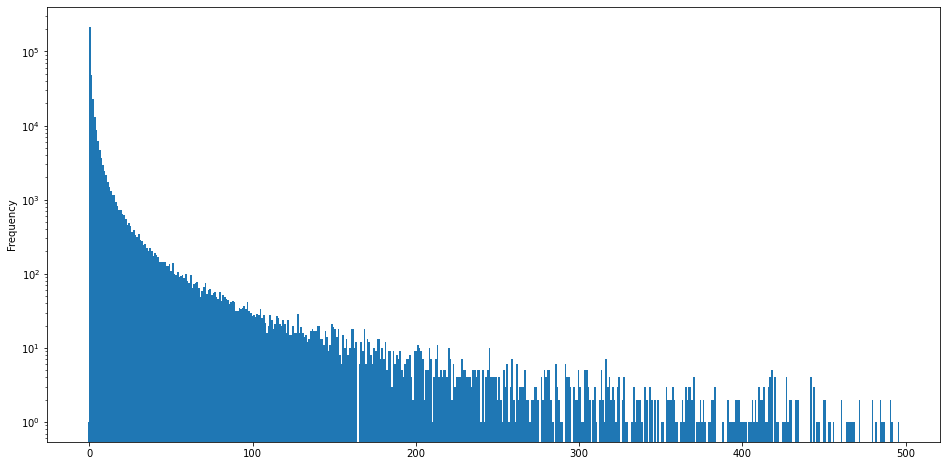

In [10]:
bins = 500
df.loc[df['feedback_quantity'] <= bins, 'feedback_quantity'].plot(kind='hist', bins=bins, logy=True, figsize=(16,8));

## View category distribution

Number of unique categories (graph leaves): 1231



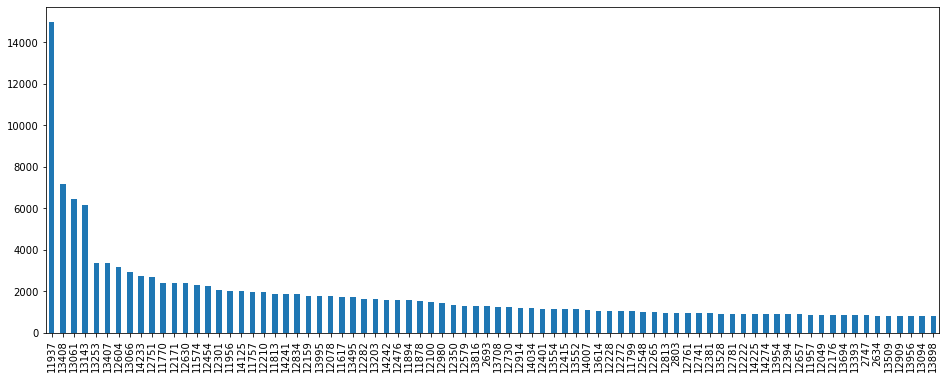

In [11]:
print('Number of unique categories (graph leaves):', df.loc[df[TRAIN], TARGET].unique().shape[0])
print()
df.loc[df[TRAIN], TARGET].value_counts().iloc[:80].plot.bar(figsize=(16, 6));

In [12]:
df.loc[df[TRAIN], TARGET].value_counts().tail()

13756    2
13007    2
2598     2
11917    2
13787    2
Name: category_id, dtype: int64

We have only 2 instances per some classes!

## Define graph from tree file

In [13]:
edgelist = [tuple(r) for r in tree[['parent_id', 'id']].to_numpy()]
G = nx.from_edgelist(edgelist, create_using=nx.DiGraph)

## Remove graph nodes that are not in the dataframe

In [14]:
# Remove leaf nodes that not in df
print('Number of deleted nodes:')
df_leaf_nodes = set(df.loc[df[TRAIN], TARGET])
while True:
    graph_leaf_nodes = {x for x in G.nodes() if G.out_degree(x)==0}
    useless_nodes = graph_leaf_nodes - df_leaf_nodes
    print(len(useless_nodes))
    if len(useless_nodes) == 0:
        break
    G.remove_nodes_from(useless_nodes)

# Remove useless 0 node
G.remove_node(0)

# Check: are there leaves in graph that are not in df?
len(df_leaf_nodes - graph_leaf_nodes)

Number of deleted nodes:
1615
228
42
10
1
0


0

All dataset instances are the leaf nodes. That's good.

## View cleaned graph

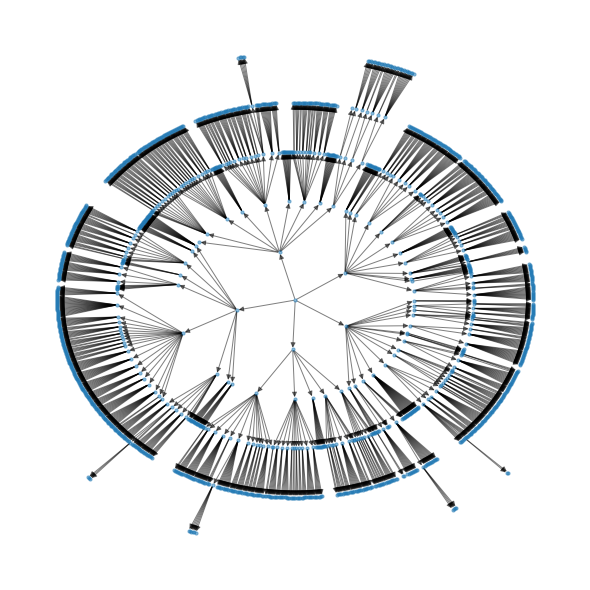

In [15]:
# Use graphviz to find radial layout
node_positions = nx.nx_agraph.graphviz_layout(G, prog='twopi', root=GRAPH_ROOT)

# Draw graph
plt.figure(figsize=(8, 8))
options = {'with_labels': False, 'alpha': 0.5, 'node_size': 10}
nx.draw(G, node_positions, **options)
plt.show()

## View categories from tree file
### View categories next to the root

In [16]:
tree.loc[tree['id'].isin(list(G.successors(GRAPH_ROOT)))]

,id,title,parent_id
325,10003,Аксессуары,1
334,10012,Красота,1
336,10014,Одежда,1
339,10018,Товары для дома,1
341,10020,Электроника,1


### View next categories

In [17]:
# Find next nodes
nodes = []
for node in G.successors(GRAPH_ROOT):
    nodes.extend(list(G.successors(node)))

# Show categories
tree.loc[tree['id'].isin(nodes)].sort_values('parent_id')

,id,title,parent_id
342,10021,Мужские аксессуары,10003
343,10022,Аксессуары для путешествий,10003
344,10023,Женские аксессуары,10003
345,10024,Аксессуары для девочек,10003
347,10026,Аксессуары для мальчиков,10003
124,2673,Ароматерапия,10012
416,10113,Маникюр и педикюр,10012
393,10084,Парфюмерия,10012
511,10232,Детям и беременным,10012
382,10070,Уход за телом,10012
